# Homework \#9

Face Tracking with KLT



## Import Modules

In [12]:
# the following two lines solved the issue of video crashing for MacOS
# you may not need those, depending on you OS
import matplotlib
matplotlib.use("TKAgg")

import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import mae6292.tools as mae6292
import importlib

from mae6292.imshow import cv2_imshow

## Problem 1

We will perform face tracking using [https://github.com/intel-iot-devkit/sample-videos](https://github.com/intel-iot-devkit/sample-videos)

### (a) Select Keypoints

1. Using 
```
    mae6292.harris_corner()
    mae6292.select_keypoints()
```
select the keypoints of `frame0` with the parameters
```
W_harris_patch = 4
harris_kappa = 0.08
W_nms = 8
N_keypoints = 1000
```

2. Convert the identififed keypoints to `2 by n` array by

```
p = np.array(keypoints, dtype='float32').T # conver list to np.array
p = p[[1,0],:] # swap row and col

```

3. Show the keypoints on `frame0` using the variable `p`

The results of this part will be similar with

<img src="prob1a_sol.png" width="500"/>

Save it into `prob1a.png`

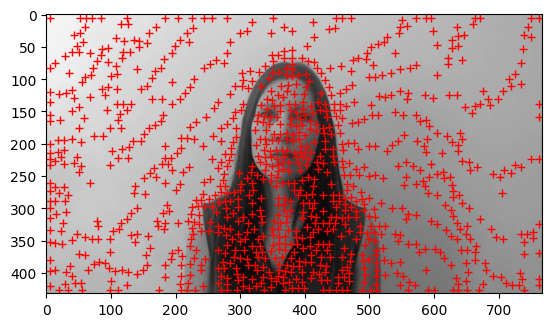

In [13]:
%matplotlib inline

frame0 = cv2.imread('data/face000000.png',cv2.IMREAD_GRAYSCALE)

W_harris_patch = 4
harris_kappa = 0.08
W_nms = 8
N_keypoints = 1000

# Compute Harris score
harris_score = mae6292.harris_corner(frame0, W_harris_patch, harris_kappa)

# Select keypoints
keypoints = mae6292.select_keypoints(harris_score, N_keypoints, W_nms)

# Convert keypoints to 2 x n array format
p0 = np.array(keypoints, dtype='float32').T
p0 = p0[[1, 0], :]  # Swap row and column to get [y; x]

plt.figure(dpi=100)
plt.imshow(frame0, cmap='gray')
plt.plot(p0[0,:], p0[1,:], 'r+')
plt.savefig('prob1a.png')
plt.show()

### (b) Select Keypoints for Face

1. The following function draw a yellow rectangle from the upper left corner `(u0,v0)` to the lower right corner `(u1,v1)`
```
def rectangle(u0, v0, u1, v1):
    plt.plot([u0, u1],[v0, v0],'y')
    plt.plot([u0, u1],[v1, v1],'y')
    plt.plot([u0, u0],[v0, v1],'y')
    plt.plot([u1, u1],[v0, v1],'y')
```
Adjust the value of `(u0,v0),(u1,v1)` so that the rectangle encloses the face.

2. Identify the keypoints within the about rectangle, and save it into `p0_face`. 

3. Show the bounding box for the face and the features in the box.

The results of this part will be similar with

<img src="prob1b_sol.png" width="500"/>

Save it into `prob1b.png`

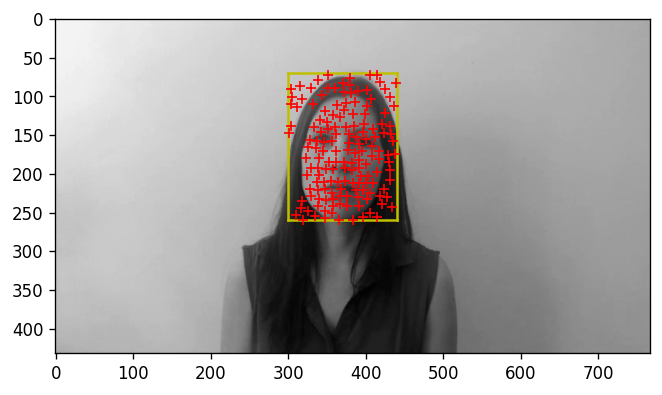

In [14]:
def rectangle(u0, v0, u1, v1):
    plt.plot([u0, u1],[v0, v0],'y')
    plt.plot([u0, u1],[v1, v1],'y')
    plt.plot([u0, u0],[v0, v1],'y')
    plt.plot([u1, u1],[v0, v1],'y')

# 1. arbitrary values    
u0, v0 = 300, 70
u1, v1 = 440, 260

# 2. Identify keypoints in the box
keypoints = mae6292.select_keypoints(harris_score, N_keypoints, W_nms)

# empty container
p0_face = np.empty((2,0), dtype='float32')
# repeat for each keypoint
for i in range(p0.shape[1]):
    ## YOUR CODE HERE:
    ## write if statement for the case that the i-th keypoint (p[0,i], p[1,i]) belongs to the box
    if u0 <= p0[0, i] <= u1 and v0 <= p0[1, i] <= v1: ##(Conditions)
        p0_face = np.append(p0_face, p0[:,i].reshape(2,1), axis=1)

# 3. Plot box and feaatures, adjust (u0,v0), (u1,v1) manually        
plt.figure(dpi=120)
plt.imshow(frame0, cmap='gray')
rectangle(u0,v0, u1,v1)
plt.plot(p0_face[0,:], p0_face[1,:], 'r+')

plt.savefig('prob1b.png')
plt.show()

## Problem 2

### (a)

Now, we are going to track the features within the bounding box, using KLT. 

1. Load `frame1`.
2. Tack the above face features `p0_face` from `frame0` and `frame` using

```
p1, index_track = mae6292.KLT(frame0, frame1, p0_face, W = 7, tol_bidir = 10, display = False)
p1_face = p1[:,index_track]

```

3. Determine `(u0,v0), (u1,v1)` for the new bounding box enclosing `p1_face`. For example
```
u0 = np.amin(p1_face[0,:])
```
4. Show the new bounding box for the face and the features in `frame1`


The results of this part will be similar with

<img src="prob2a_sol.png" width="500"/>

Save it into `prob2a.png`


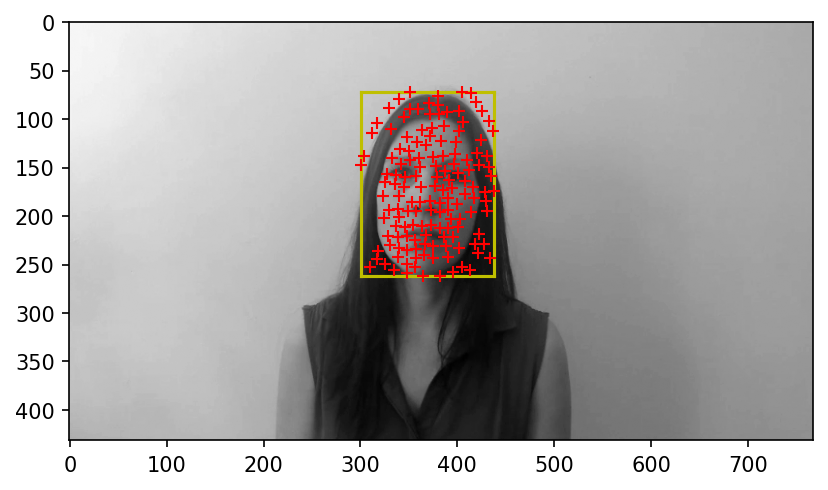

In [15]:
frame1 = cv2.imread('data/face000001.png',cv2.IMREAD_GRAYSCALE)

p1, index_track = mae6292.KLT(frame0, frame1, p0_face, W = 7, tol_bidir = 1, display = False)
p1_face = p1[:,index_track]

# To define (u0,v0) , (u1,v1)
# Define bounding box based on tracked points
u0 = np.amin(p1_face[0, :])
v0 = np.amin(p1_face[1, :])
u1 = np.amax(p1_face[0, :])
v1 = np.amax(p1_face[1, :])

# Plotting
plt.figure(dpi=150)
plt.imshow(frame1, cmap='gray')
rectangle(u0, v0, u1, v1)
plt.plot(p1_face[0,:], p1_face[1,:], 'r+')

plt.savefig('prob2a.png')
plt.show()

### (b)

Repeat the above tracking up to the first 100 frames. The last plot will be similar with


<img src="prob2b_sol.png" width="500"/>


Save the last plot as `prob2b.png`


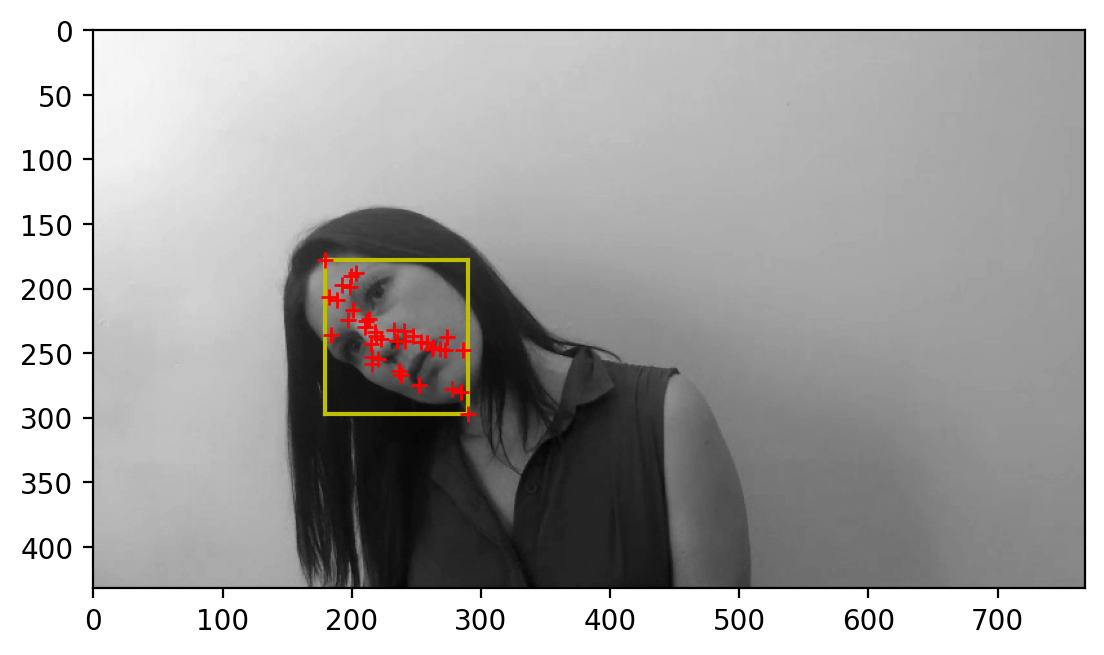

In [16]:
# draw figures within jupyter
%matplotlib inline

frame_pre = frame0
p_face_pre = p0_face

plt.figure(dpi=200) # Comment for multiple figures

for i in range(1,100):
    frame = cv2.imread("data/face{:06d}.png".format(i),cv2.IMREAD_GRAYSCALE)

    ## YOUR CODE HERE
    # Track `p_face_pre` from frame_pre to frame
    p, index_track = mae6292.KLT(frame_pre, frame, p_face_pre, W=7, tol_bidir=1, display=False)
    p_face = p[:, index_track]

    # choose (u0, v0), (u1, v1)
    u0 = np.amin(p_face[0, :])
    v0 = np.amin(p_face[1, :])
    u1 = np.amax(p_face[0, :])
    v1 = np.amax(p_face[1, :])
    
    # Clear previous content
    plt.clf()
    
    # show results
    # plt.figure(dpi=50) # Uncomment for multiple figures
    plt.imshow(frame, cmap='gray')
    rectangle(u0,v0, u1,v1)
    plt.plot(p_face[0,:], p_face[1,:], 'r+')

    p_face_pre = p_face
    frame_pre = frame

plt.savefig('prob2b.png')
plt.show()

### (c)

Here we will read and save videos using OpenCV. Read the tutorial [Getting Started with Videos](https://docs.opencv.org/master/dd/d43/tutorial_py_video_display.html). 

The following code will 
1. read the each frame of the video
2. draw an arbitrary box
3. display each frame
4. save the video into `prob2c.mp4`

Modify codes within the lines closed by `#####` such that the results of 2.(b) is saved into a video file, `prob2c.mp4`


In [17]:
# open a new window for plot
%matplotlib tk

# open a video file to read
video_read = cv2.VideoCapture('head-pose-face-detection-female.mp4')

# get frame size and fps (number of frames per second)
width = int(video_read.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_read.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video_read.get(cv2.CAP_PROP_FPS)
size = (width, height)

# open a video file to save
codec = cv2.VideoWriter_fourcc(*'avc1')
video_save = cv2.VideoWriter('prob2c.mp4', codec, fps, size)

# to initiate the iteration, the first frame is saved to `frame_pre`
ret, frame_color = video_read.read() # color frame
frame_pre = cv2.cvtColor(frame_color, cv2.COLOR_BGR2GRAY) # grayscale frame
p_face_pre = p0_face # face features for the first frame

# repeat for each frame
for i in range(1,300):    

    # read a new frame
    ret, frame_color = video_read.read() # color frame
    if not ret:
        break
    frame = cv2.cvtColor(frame_color, cv2.COLOR_BGR2GRAY) #grayscale frame
    
    ############################################
    ## YOUR CODE HERE
    
    # 1. Track p_face_pre from frame_pre to frame, save the tracked frame into p_face
    p, index_track = mae6292.KLT(frame_pre, frame, p_face_pre, W=7, tol_bidir=5, display=False)
    p_face = p[:, index_track]
    
    # 2. Compute (u0,v0), (u1,v1) for the new bounding box using p_face
    u0 = np.amin(p_face[0, :])
    v0 = np.amin(p_face[1, :])
    u1 = np.amax(p_face[0, :])
    v1 = np.amax(p_face[1, :])
    
    # 3. Draw a rectangle on the color frame
    cv2.rectangle(frame_color, (int(u0),int(v0)), (int(u1),int(v1)), (0, 255,255))     
    
    # 4. current frame and features are saved into pre-frame and pre-feataures, for the next iteration
    frame_pre = frame
    p_face_pre = p_face
    #############################################   

    #show the frame 
    cv2.imshow('frame',frame_color)
    if cv2.waitKey(1) == ord('q'): # stop if "q" is pressed
        break   

    #save the frame
    video_save.write(frame_color)

# release video files       
video_read.release()
video_save.release()
cv2.destroyAllWindows()

## Problem 3

Record a short video of yourself and perform face tracking using the above code. Save it into `prob3.mp4`

1. Your video can be about 5 seconds or so.
2. Try to reduce the resolution. For example, the resolution of the above video is `(768, 432)`
3. You may need to tune the following parameters for Harris feature detector
```
W_harris_patch = 4
harris_kappa = 0.08
W_nms = 8
N_keypoints = 1000
```
and the following parameters `W` and `tol_bidir` in KLT

```
p, index_track = mae6292.KLT(frame_pre, frame, p_face_pre, W = 7, tol_bidir = 10, display = False)
```



In [ ]:
# Save the first frame of the video
# Open the video file
video = cv2.VideoCapture('face-detection-MinThiha.mp4')

# Read the first frame
ret, frame = video.read()

# Check if the frame was read successfully
if ret:
    # Save the frame as an image
    cv2.imwrite('Min000000.png', frame)
else:
    print("Failed to read the first frame")

# Release the video
video.release()

<Figure size 640x480 with 0 Axes>

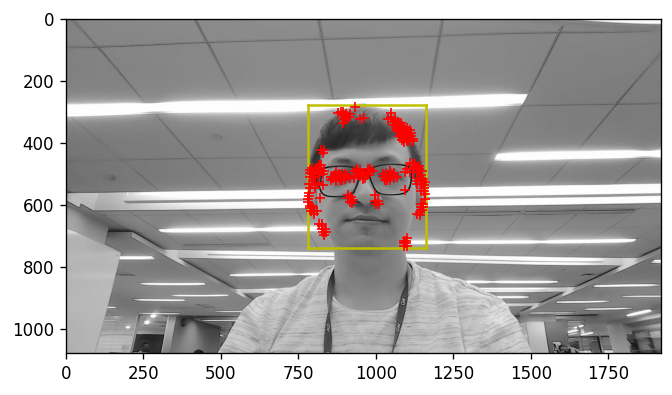

In [ ]:
%matplotlib inline

frame0 = cv2.imread('Min000000.png',cv2.IMREAD_GRAYSCALE)

W_harris_patch = 10
harris_kappa = 0.08
W_nms = 8
N_keypoints = 1000

# Compute Harris score
harris_score = mae6292.harris_corner(frame0, W_harris_patch, harris_kappa)

# Select keypoints
keypoints = mae6292.select_keypoints(harris_score, N_keypoints, W_nms)

# Convert keypoints to 2 x n array format
p0 = np.array(keypoints, dtype='float32').T
p0 = p0[[1, 0], :]  # Swap row and column to get [y; x]

def rectangle(u0, v0, u1, v1):
    plt.plot([u0, u1],[v0, v0],'y')
    plt.plot([u0, u1],[v1, v1],'y')
    plt.plot([u0, u0],[v0, v1],'y')
    plt.plot([u1, u1],[v0, v1],'y')

# 1. arbitrary values    
u0, v0 = 780, 280
u1, v1 = 1160, 740

# 2. Identify keypoints in the box
keypoints = mae6292.select_keypoints(harris_score, N_keypoints, W_nms)

# empty container
p0_face = np.empty((2,0), dtype='float32')
# repeat for each keypoint
for i in range(p0.shape[1]):
    ## YOUR CODE HERE:
    ## write if statement for the case that the i-th keypoint (p[0,i], p[1,i]) belongs to the box
    if u0 <= p0[0, i] <= u1 and v0 <= p0[1, i] <= v1: ##(Conditions)
        p0_face = np.append(p0_face, p0[:,i].reshape(2,1), axis=1)
plt.clf()
# 3. Plot box and feaatures, adjust (u0,v0), (u1,v1) manually        
plt.figure(dpi=120)
plt.imshow(frame0, cmap='gray')
rectangle(u0,v0, u1,v1)
plt.plot(p0_face[0,:], p0_face[1,:], 'r+')
plt.show()

In [ ]:
# open a new window for plot
%matplotlib tk

# open a video file to read
video_read = cv2.VideoCapture('face-detection-MinThiha.mp4')

# get frame size and fps (number of frames per second)
width = int(video_read.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video_read.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video_read.get(cv2.CAP_PROP_FPS)
size = (width, height)

# open a video file to save
codec = cv2.VideoWriter_fourcc(*'avc1')
video_save = cv2.VideoWriter('prob3.mp4', codec, fps, size)

# to initiate the iteration, the first frame is saved to `frame_pre`
ret, frame_color = video_read.read() # color frame

frame_pre = cv2.cvtColor(frame_color, cv2.COLOR_BGR2GRAY) # grayscale frame
p_face_pre = p0_face # face features for the first frame

# repeat for each frame
for i in range(1,300):    

    # read a new frame
    ret, frame_color = video_read.read() # color frame
    if not ret:
        break

    frame = cv2.cvtColor(frame_color, cv2.COLOR_BGR2GRAY) #grayscale frame
    
    ############################################
    ## YOUR CODE HERE
    
    # 1. Track p_face_pre from frame_pre to frame, save the tracked frame into p_face
    p, index_track = mae6292.KLT(frame_pre, frame, p_face_pre, W=30, tol_bidir=8, display=False)
    p_face = p[:, index_track]
    
    # 2. Compute (u0,v0), (u1,v1) for the new bounding box using p_face
    u0 = np.amin(p_face[0, :])
    v0 = np.amin(p_face[1, :])
    u1 = np.amax(p_face[0, :])
    v1 = np.amax(p_face[1, :])
    
    # 3. Draw a rectangle on the color frame
    cv2.rectangle(frame_color, (int(u0),int(v0)), (int(u1),int(v1)), (0, 255,255))     
    
    # 4. current frame and features are saved into pre-frame and pre-feataures, for the next iteration
    frame_pre = frame
    p_face_pre = p_face
    #############################################   

#    show the frame 
    cv2.imshow('frame',frame_color)
    if cv2.waitKey(1) == ord('q'): # stop if "q" is pressed
        break   

 #   save the frame
    video_save.write(frame_color)

# release video files       
video_read.release()
video_save.release()
cv2.destroyAllWindows()

### How To Submit

Attach

1.  `prob1a.png`, `prob1b.png`
2.  `prob2a.png`, `prob2b.png`, `prob2c.mp4`
3.  `prob3.mp4`